In [38]:
from utils.tushare_utils import IndexAnalysis
from utils.date_utils import Date_utils
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def create_stock_chart(stock_code, start_date, end_date, k_bars_to_show=1000):
    """
    创建单个股票的K线图和成交量图表
    
    参数:
    stock_code: 股票代码
    start_date: 开始日期
    end_date: 结束日期
    k_bars_to_show: 显示的K线数量
    
    返回:
    fig: Plotly图表对象
    """
    # 获取股票数据
    try:
        df = IndexAnalysis.my_pro_bar(stock_code, start_date=start_date, end_date=end_date)
        if df.empty:
            print(f"无法获取 {stock_code} 的数据")
            return None
    except Exception as e:
        print(f"获取 {stock_code} 数据时出错: {e}")
        return None
    
    # 数据预处理
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    df = df.iloc[-k_bars_to_show:] if len(df) > k_bars_to_show else df
    df['trade_date_copy'] = df['trade_date'].copy()

    df.set_index('trade_date', inplace=True)

    df.sort_index(inplace=True)
    
    # 重命名价格列
    df.rename(columns={
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'vol': 'Volume'
    }, inplace=True)
    
    # 计算多条移动平均线
    df['MA5'] = df['Close'].rolling(window=5, min_periods=1).mean()
    df['MA10'] = df['Close'].rolling(window=10, min_periods=1).mean()
    df['MA20'] = df['Close'].rolling(window=20, min_periods=1).mean()
    df['MA30'] = df['Close'].rolling(window=30, min_periods=1).mean()
    df['MA60'] = df['Close'].rolling(window=60, min_periods=1).mean()
    df['MA120'] = df['Close'].rolling(window=120, min_periods=1).mean()
    
    # 创建交互式K线图
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        subplot_titles=(f'{stock_code} K线图与移动平均线', '成交量'),
        row_heights=[0.7, 0.3]
    )
    
    # 添加K线图 - 使用数值索引而不是日期索引
    date_strings = df.index.strftime('%Y-%m-%d').tolist()
    fig.add_trace(
        go.Candlestick(
            x=list(range(len(df))),  # 使用数值索引
            text= df['trade_date_copy'],
            open=df['Open'],
            high=df['High'],
            low=df['Low'],
            close=df['Close'],
            name='K线',
            increasing_line_color='red',
            decreasing_line_color='green'
        ),
        row=1, col=1
    )
    
    # 添加多条移动平均线
    ma_colors = {
        'MA5': 'black',
        'MA10': 'yellow',
        'MA20': 'pink',
        'MA30': 'green',
        'MA60': 'blue',
        'MA120': 'brown'
    }
    
    for ma_name, color in ma_colors.items():
        if ma_name in df.columns:
            fig.add_trace(
                go.Scatter(
                    x=list(range(len(df))),  # 使用数值索引
                    y=df[ma_name],
                    line=dict(color=color, width=1.5),
                    name=ma_name,
                    connectgaps=True,
                    # 去掉移动平均线的悬浮提示
                    hoverinfo='skip'
                ),
                row=1, col=1
            )
    
    # 添加成交量图
    if 'Volume' in df.columns:
        # 根据价格涨跌设置成交量颜色
        colors = ['red' if close >= open else 'green' 
                  for close, open in zip(df['Close'], df['Open'])]
        
        fig.add_trace(
            go.Bar(
                x=list(range(len(df))),  # 使用数值索引
                y=df['Volume'],
                name='成交量',
                marker_color=colors,
                opacity=0.7,
                marker_line_width=0,
                width=0.8  # 设置柱子宽度为0.8个单位
            ),
            row=2, col=1
        )
    
    # 更新图表布局
    fig.update_layout(
        title=f'{stock_code} 股票K线图 (最近{len(df)}个交易日)',
        yaxis_title='价格',
        xaxis_title='时间',
        template='plotly_white',
        height=600,
        width=1200,
        showlegend=True,
        xaxis_rangeslider_visible=False,
        margin=dict(l=50, r=50, t=80, b=50),
        bargap=0,
        # 设置X轴刻度
        xaxis=dict(
            tickmode='array',
            tickvals=list(range(len(df))),
            ticktext=date_strings,
            rangeslider=dict(visible=False)
        )
    )
    
    # 更新X轴设置 - 使用数值索引
    fig.update_xaxes(
        row=1, col=1,
        tickmode='array',
        tickvals=list(range(0, len(df), max(1, len(df)//10))),  # 大约显示10个刻度
        ticktext=[date_strings[i] for i in range(0, len(df), max(1, len(df)//10))]
    )
    
    fig.update_xaxes(
        title_text='时间',
        row=2, col=1,
        tickmode='array',
        tickvals=list(range(0, len(df), max(1, len(df)//10))),  # 大约显示10个刻度
        ticktext=[date_strings[i] for i in range(0, len(df), max(1, len(df)//10))]
    )
    
    # 更新Y轴设置
    fig.update_yaxes(
        title_text='价格',
        row=1, col=1,
        fixedrange=False
    )
    
    if 'Volume' in df.columns:
        fig.update_yaxes(
            title_text='成交量',
            row=2, col=1,
            fixedrange=False
        )
    
    
    return fig

def display_multiple_stocks(stock_codes, start_date=None, end_date=None, k_bars_to_show=1000):
    """
    显示多只股票的K线图
    
    参数:
    stock_codes: 股票代码列表
    start_date: 开始日期，默认为None（使用100天前）
    end_date: 结束日期，默认为None（使用今天）
    k_bars_to_show: 显示的K线数量
    """
    # 设置默认日期
    if start_date is None:
        start_date = Date_utils.get_date_by_step(Date_utils.get_today(replace=True), -100)
    if end_date is None:
        end_date = Date_utils.get_today(replace=True)
    
    # 为每只股票创建图表
    figures = []
    for stock_code in stock_codes:
        print(f"正在处理 {stock_code}...")
        fig = create_stock_chart(stock_code, start_date, end_date, k_bars_to_show)
        if fig is not None:
            figures.append((stock_code, fig))
    
    # 显示所有图表
    for i, (stock_code, fig) in enumerate(figures):
        print(f"显示图表 {i+1}/{len(figures)}: {stock_code}")
        fig.show(config={'scrollZoom': True})
    
    return figures

# 使用示例
if __name__ == "__main__":
    # 定义要显示的股票代码列表
    stock_codes = ['000001.SH']  # 上证指数、深证成指、沪深300
    
    # 显示多只股票的图表
    figures = display_multiple_stocks(
        stock_codes=stock_codes,
        start_date=Date_utils.get_date_by_step(Date_utils.get_today(replace=True), -200),  # 200天前
        end_date=Date_utils.get_today(replace=True),  # 今天
        k_bars_to_show=1000  # 显示最近1000根K线
    )

正在处理 000001.SH...
显示图表 1/1: 000001.SH


In [34]:
from utils.date_utils import Date_utils
from utils.tushare_utils import pro

df = pro.stk_mins(ts_code='600104.SH', freq='1min', start_date='2025-09-11 09:00:00', end_date='2025-09-12 19:02:00')
print(df)

       ts_code           trade_time  close   open   high    low        vol      amount
0    600104.SH  2025-09-12 15:00:00  18.55  18.55  18.55  18.55  1099900.0  20403144.0
1    600104.SH  2025-09-12 14:59:00  18.58  18.58  18.58  18.58        0.0         0.0
2    600104.SH  2025-09-12 14:58:00  18.58  18.58  18.58  18.58      300.0      5574.0
3    600104.SH  2025-09-12 14:57:00  18.59  18.58  18.59  18.57   305144.0   5671036.0
4    600104.SH  2025-09-12 14:56:00  18.58  18.57  18.58  18.57   423200.0   7860863.0
..         ...                  ...    ...    ...    ...    ...        ...         ...
477  600104.SH  2025-09-11 09:34:00  18.76  18.76  18.78  18.76   357900.0   6716490.0
478  600104.SH  2025-09-11 09:33:00  18.77  18.75  18.79  18.75   259000.0   4859644.0
479  600104.SH  2025-09-11 09:32:00  18.75  18.81  18.81  18.74   371000.0   6964179.0
480  600104.SH  2025-09-11 09:31:00  18.81  18.87  18.88  18.80   279400.0   5265254.0
481  600104.SH  2025-09-11 09:30:00  18.90 

C:\Users\wcao16\AppData\Local\Temp\1\ipykernel_37500\3881569777.py:49: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from current font.
  plt.tight_layout()
C:\Users\wcao16\AppData\Local\Temp\1\ipykernel_37500\3881569777.py:49: UserWarning: Glyph 31163 (\N{CJK UNIFIED IDEOGRAPH-79BB}) missing from current font.
  plt.tight_layout()
C:\Users\wcao16\AppData\Local\Temp\1\ipykernel_37500\3881569777.py:49: UserWarning: Glyph 30334 (\N{CJK UNIFIED IDEOGRAPH-767E}) missing from current font.
  plt.tight_layout()
C:\Users\wcao16\AppData\Local\Temp\1\ipykernel_37500\3881569777.py:49: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
C:\Users\wcao16\AppData\Local\Temp\1\ipykernel_37500\3881569777.py:49: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  plt.tight_layout()
C:\Users\wcao16\AppData\Local\Temp\1\ipykernel_37500\3881569777.py:49: UserWarning: Glyph 24658 (\N{CJK UNIFIED IDE

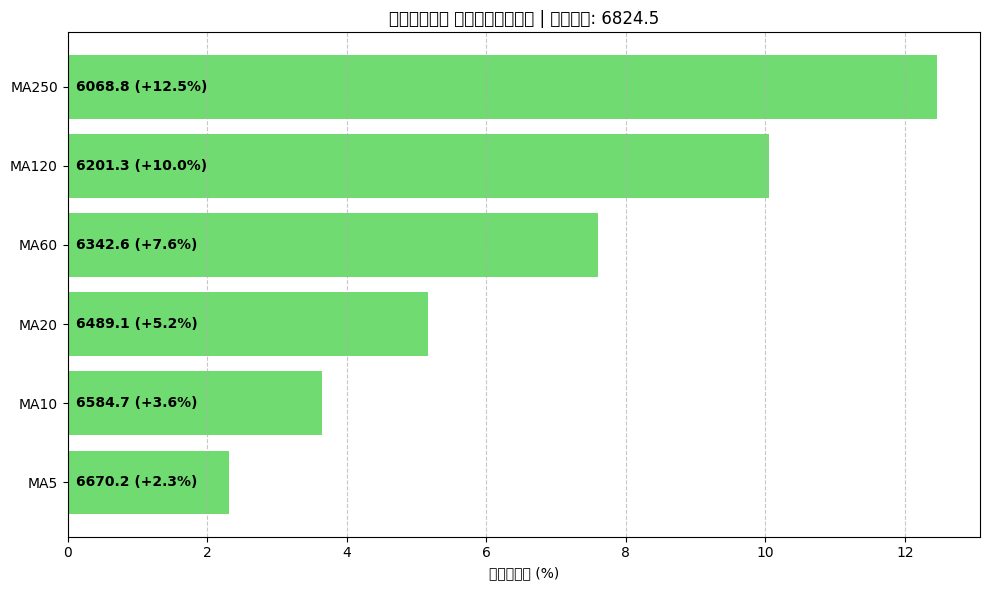

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据
symbol = "恒生科技指数"
price = 6824.5
ma_values = {
    'MA5': 6670.2, 
    'MA10': 6584.7,
    'MA20': 6489.1,
    'MA60': 6342.6,
    'MA120': 6201.3,
    'MA250': 6068.8
}

# 计算偏差百分比
deviations = {k: (price - v)/v * 100 for k,v in ma_values.items()}

# 创建热力图
fig, ax = plt.subplots(figsize=(10, 6))
periods = list(ma_values.keys())
dev_values = [deviations[p] for p in periods]

# 创建颜色映射 (红色到绿色)
colors = ['#ff4d4d' if d < 0 else '#33cc33' for d in dev_values]
color_intensity = [abs(d)/max(map(abs, dev_values)) for d in dev_values]  # 强度归一化

# 绘制条形图
bars = ax.barh(periods, dev_values, color=colors, alpha=0.7)

# 添加数据标签
for i, (value, dev) in enumerate(zip(ma_values.values(), dev_values)):
    sign = '+' if dev >= 0 else ''
    ax.text(max(dev_values)*0.01, i, 
            f"{value:.1f} ({sign}{dev:.1f}%)", 
            va='center', ha='left', fontweight='bold')

# 添加预警标记
thresholds = {'MA20': 8, 'MA60': 15}
for i, p in enumerate(periods):
    if p in thresholds and abs(deviations[p]) > thresholds[p]:
        marker = '⚠️' if p == 'MA20' else '⚡'
        ax.text(dev_values[i], i, marker, 
                va='center', ha='right', fontsize=16)

plt.title(f"{symbol} 价格均线偏离分析 | 当前价格: {price}")
plt.xlabel('偏离百分比 (%)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()